In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 10,
    'dropout'       : 0.75,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_075_1024_512_256_128_0001_MSE_10_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_t1_mask_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 934)
(631390, 1)
validation
(74368, 934)
(74368, 1)
test
(85358, 934)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 934)]             0         


 dense (Dense)               (None, 1024)              957440    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1646593 (6.28 MB)


Trainable params: 1646593 (6.28 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/632 [..............................] - ETA: 11:46 - loss: 0.0642 - STD: 1.2623e-04 - MAE: 0.2440

 12/632 [..............................] - ETA: 2s - loss: 0.0245 - STD: 2.9985e-04 - MAE: 0.1105   

 24/632 [>.............................] - ETA: 2s - loss: 0.0192 - STD: 4.3743e-04 - MAE: 0.0973

 36/632 [>.............................] - ETA: 2s - loss: 0.0172 - STD: 6.1004e-04 - MAE: 0.0891

 48/632 [=>............................] - ETA: 2s - loss: 0.0160 - STD: 9.0315e-04 - MAE: 0.0831

 60/632 [=>............................] - ETA: 2s - loss: 0.0153 - STD: 0.0016 - MAE: 0.0811    

 70/632 [==>...........................] - ETA: 2s - loss: 0.0148 - STD: 0.0030 - MAE: 0.0791

 80/632 [==>...........................] - ETA: 2s - loss: 0.0141 - STD: 0.0062 - MAE: 0.0767

 92/632 [===>..........................] - ETA: 2s - loss: 0.0130 - STD: 0.0138 - MAE: 0.0726

104/632 [===>..........................] - ETA: 2s - loss: 0.0119 - STD: 0.0224 - MAE: 0.0687

115/632 [====>.........................] - ETA: 2s - loss: 0.0111 - STD: 0.0294 - MAE: 0.0657

127/632 [=====>........................] - ETA: 2s - loss: 0.0104 - STD: 0.0360 - MAE: 0.0628

139/632 [=====>........................] - ETA: 2s - loss: 0.0097 - STD: 0.0410 - MAE: 0.0604

151/632 [======>.......................] - ETA: 2s - loss: 0.0092 - STD: 0.0458 - MAE: 0.0584

162/632 [======>.......................] - ETA: 2s - loss: 0.0087 - STD: 0.0493 - MAE: 0.0567

174/632 [=======>......................] - ETA: 2s - loss: 0.0083 - STD: 0.0527 - MAE: 0.0550

186/632 [=======>......................] - ETA: 2s - loss: 0.0079 - STD: 0.0557 - MAE: 0.0536

198/632 [========>.....................] - ETA: 1s - loss: 0.0076 - STD: 0.0583 - MAE: 0.0522

210/632 [========>.....................] - ETA: 1s - loss: 0.0073 - STD: 0.0607 - MAE: 0.0510

222/632 [=========>....................] - ETA: 1s - loss: 0.0070 - STD: 0.0630 - MAE: 0.0499

233/632 [==========>...................] - ETA: 1s - loss: 0.0067 - STD: 0.0648 - MAE: 0.0490

245/632 [==========>...................] - ETA: 1s - loss: 0.0065 - STD: 0.0666 - MAE: 0.0481

257/632 [===========>..................] - ETA: 1s - loss: 0.0063 - STD: 0.0684 - MAE: 0.0472

269/632 [===========>..................] - ETA: 1s - loss: 0.0061 - STD: 0.0698 - MAE: 0.0464

281/632 [============>.................] - ETA: 1s - loss: 0.0059 - STD: 0.0713 - MAE: 0.0457

293/632 [============>.................] - ETA: 1s - loss: 0.0057 - STD: 0.0727 - MAE: 0.0450

305/632 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0738 - MAE: 0.0443

318/632 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0751 - MAE: 0.0437

330/632 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0761 - MAE: 0.0432

342/632 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0770 - MAE: 0.0427

354/632 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0779 - MAE: 0.0422

366/632 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0787 - MAE: 0.0417

378/632 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0413

390/632 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0802 - MAE: 0.0410

403/632 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0811 - MAE: 0.0406

415/632 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0819 - MAE: 0.0402

427/632 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0825 - MAE: 0.0399

439/632 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0832 - MAE: 0.0396

451/632 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0838 - MAE: 0.0392

463/632 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0843 - MAE: 0.0390

475/632 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0848 - MAE: 0.0387

487/632 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0853 - MAE: 0.0384

499/632 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0857 - MAE: 0.0382

511/632 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0862 - MAE: 0.0379

523/632 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0867 - MAE: 0.0377

535/632 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0870 - MAE: 0.0375

547/632 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0874 - MAE: 0.0373

559/632 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0878 - MAE: 0.0370

566/632 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0880 - MAE: 0.0369

577/632 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0883 - MAE: 0.0368

589/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0886 - MAE: 0.0366

601/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0889 - MAE: 0.0364

613/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0893 - MAE: 0.0362

625/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0896 - MAE: 0.0360

632/632 [==============================] - 5s 6ms/step - loss: 0.0036 - STD: 0.0897 - MAE: 0.0359 - val_loss: 0.0016 - val_STD: 0.0784 - val_MAE: 0.0287


Epoch 2/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0015 - STD: 0.1074 - MAE: 0.0266

 13/632 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0273 

 25/632 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0273

 37/632 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0272

 49/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0271

 61/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0272

 73/632 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

 85/632 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

 98/632 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0272

110/632 [====>.........................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

122/632 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0271

134/632 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0271

146/632 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0272

158/632 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

170/632 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

182/632 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

194/632 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0272

206/632 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0271

218/632 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0271

230/632 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

242/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0271

254/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0271

266/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0271

279/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0271

291/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

303/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

316/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

329/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

341/632 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

353/632 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

365/632 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

377/632 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

390/632 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

402/632 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0271

415/632 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

428/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

441/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

453/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

465/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

477/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

490/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

503/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

515/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

527/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

539/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

551/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

563/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

574/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

586/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

598/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

610/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

622/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

632/632 [==============================] - 3s 5ms/step - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270 - val_loss: 0.0015 - val_STD: 0.0786 - val_MAE: 0.0278


Epoch 3/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0265

 12/632 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0263 

 23/632 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0262

 35/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

 47/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

 59/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0261

 72/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0261

 83/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0261

 95/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

107/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

119/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

132/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0261

145/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0263

157/632 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

169/632 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0265

181/632 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

193/632 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

205/632 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

217/632 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

227/632 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

238/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

250/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

262/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

274/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

287/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

300/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

313/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

326/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

338/632 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

350/632 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

362/632 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

374/632 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

386/632 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

398/632 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

410/632 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

422/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

434/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

446/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

459/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

471/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

483/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

495/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

507/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

519/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

531/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

543/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

555/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

567/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

579/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

591/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

603/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

615/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

627/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

632/632 [==============================] - 3s 5ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264 - val_loss: 0.0014 - val_STD: 0.0782 - val_MAE: 0.0273


Epoch 4/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0279

 12/632 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0265 

 24/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0264

 36/632 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0271

 48/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

 60/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

 72/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0263

 83/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

 94/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

104/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

115/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

126/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

137/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

147/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0258

158/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

168/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

178/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

189/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

200/632 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

211/632 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

222/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

233/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

245/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

256/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

268/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

280/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

290/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

301/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

313/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

325/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

338/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

350/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

362/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

374/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

386/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

398/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

411/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

423/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

435/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

447/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

459/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

471/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

483/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

495/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

507/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

519/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

531/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

543/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

555/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

568/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

581/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

593/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

605/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

618/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

630/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

632/632 [==============================] - 3s 5ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260 - val_loss: 0.0013 - val_STD: 0.0781 - val_MAE: 0.0264


Epoch 5/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0012 - STD: 0.1011 - MAE: 0.0247

 12/632 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0266 

 23/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1074 - MAE: 0.0261

 35/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0257

 47/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0256

 58/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0257

 69/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0259

 79/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0257

 88/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0257

 98/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0257

109/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0256

119/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0256

129/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0255

140/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

153/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

165/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

177/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0255

190/632 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0255

202/632 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0256

214/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

226/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

238/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

250/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

262/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

274/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

286/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

298/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

310/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

322/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

334/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

346/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

357/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

369/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

379/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

389/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

399/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

410/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

420/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

430/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

440/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

450/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

461/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

472/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

484/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

496/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

508/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

520/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

533/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

546/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

558/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

570/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

582/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

594/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

606/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

619/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

631/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

632/632 [==============================] - 3s 5ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255 - val_loss: 0.0014 - val_STD: 0.0793 - val_MAE: 0.0261


Epoch 6/10000


  1/632 [..............................] - ETA: 10s - loss: 0.0015 - STD: 0.0995 - MAE: 0.0264

 13/632 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0263 

 25/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

 36/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

 48/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0259

 60/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0260

 71/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0260

 83/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0258

 95/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

107/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

119/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

131/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

143/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

155/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

166/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

177/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

188/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

198/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

209/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

220/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

232/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0255

244/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0254

256/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0255

269/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0255

281/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

293/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0255

303/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0255

313/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0254

324/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0254

334/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0254

345/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0254

357/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0254

369/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0254

380/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

391/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

403/632 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

415/632 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

427/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

439/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

451/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

463/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

475/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

487/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

499/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

511/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

523/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

535/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

547/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

559/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

571/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

583/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

595/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

607/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

619/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

631/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

632/632 [==============================] - 3s 5ms/step - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251 - val_loss: 0.0021 - val_STD: 0.0870 - val_MAE: 0.0313


Epoch 7/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0016 - STD: 0.1139 - MAE: 0.0272

 11/632 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1090 - MAE: 0.0262 

 21/632 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1080 - MAE: 0.0256

 32/632 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1076 - MAE: 0.0257

 43/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0256

 53/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0254

 62/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0252

 72/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0252

 82/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1074 - MAE: 0.0250

 91/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0249

101/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0249

111/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0249

120/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0249

130/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0249

140/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0249

150/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

160/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

170/632 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

180/632 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

190/632 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

202/632 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

214/632 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

225/632 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

237/632 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

249/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

261/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

273/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

285/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

297/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

309/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

321/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

333/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

345/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

357/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

369/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

381/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0248

393/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

405/632 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

417/632 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

429/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

441/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

453/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

465/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

477/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

489/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

501/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

513/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

526/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

538/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

549/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

561/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

573/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

585/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

596/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

608/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

620/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

632/632 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

632/632 [==============================] - 3s 5ms/step - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247 - val_loss: 0.0022 - val_STD: 0.0902 - val_MAE: 0.0310


Epoch 8/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0012 - STD: 0.1172 - MAE: 0.0244

 12/632 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248 

 24/632 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0248

 36/632 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0246

 48/632 [=>............................] - ETA: 2s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0245

 60/632 [=>............................] - ETA: 2s - loss: 0.0012 - STD: 0.1076 - MAE: 0.0243

 72/632 [==>...........................] - ETA: 2s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0242

 85/632 [===>..........................] - ETA: 2s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0242

 97/632 [===>..........................] - ETA: 2s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0243

109/632 [====>.........................] - ETA: 2s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0245

121/632 [====>.........................] - ETA: 2s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0245

131/632 [=====>........................] - ETA: 2s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0245

142/632 [=====>........................] - ETA: 2s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0244

154/632 [======>.......................] - ETA: 2s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0244

166/632 [======>.......................] - ETA: 2s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0244

178/632 [=======>......................] - ETA: 2s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0243

190/632 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0243

201/632 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

211/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

221/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

232/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

243/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0244

254/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0244

265/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

277/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

289/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

301/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

313/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

325/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

337/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

349/632 [===============>..............] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

361/632 [================>.............] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243

373/632 [================>.............] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

385/632 [=================>............] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

397/632 [=================>............] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

409/632 [==================>...........] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

421/632 [==================>...........] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

433/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

445/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

457/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

468/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

479/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

491/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

503/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0242

515/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

527/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

539/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

551/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

563/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

575/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241

587/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241

599/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241

611/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241

623/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241

632/632 [==============================] - 3s 5ms/step - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241 - val_loss: 0.0015 - val_STD: 0.0840 - val_MAE: 0.0270


Epoch 9/10000


  1/632 [..............................] - ETA: 10s - loss: 0.0012 - STD: 0.1051 - MAE: 0.0237

 11/632 [..............................] - ETA: 3s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0238 

 21/632 [..............................] - ETA: 3s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0236

 31/632 [>.............................] - ETA: 3s - loss: 0.0012 - STD: 0.1060 - MAE: 0.0236

 41/632 [>.............................] - ETA: 3s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0236

 51/632 [=>............................] - ETA: 3s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0235

 61/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0235

 72/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0236

 84/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0235

 96/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0236

108/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1065 - MAE: 0.0236

120/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1064 - MAE: 0.0236

132/632 [=====>........................] - ETA: 2s - loss: 0.0012 - STD: 0.1063 - MAE: 0.0237

144/632 [=====>........................] - ETA: 2s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0237

156/632 [======>.......................] - ETA: 2s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0237

168/632 [======>.......................] - ETA: 2s - loss: 0.0012 - STD: 0.1063 - MAE: 0.0237

180/632 [=======>......................] - ETA: 2s - loss: 0.0012 - STD: 0.1063 - MAE: 0.0236

192/632 [========>.....................] - ETA: 2s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0237

204/632 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0237

216/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0236

228/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0236

240/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0236

252/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0236

263/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0236

275/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0236

288/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0236

300/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0236

313/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0236

325/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0236

337/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0236

349/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0236

361/632 [================>.............] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0236

372/632 [================>.............] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0236

384/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0236

396/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0236

408/632 [==================>...........] - ETA: 1s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0236

420/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0236

432/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0236

444/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0236

456/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0236

468/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0236

480/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0236

492/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0236

504/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0236

516/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0236

528/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0236

540/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0236

552/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0236

564/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0236

576/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0236

588/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

600/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0236

612/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0236

624/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

632/632 [==============================] - 3s 5ms/step - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236 - val_loss: 0.0016 - val_STD: 0.0865 - val_MAE: 0.0269


Epoch 10/10000


  1/632 [..............................] - ETA: 9s - loss: 0.0013 - STD: 0.1073 - MAE: 0.0243

 14/632 [..............................] - ETA: 2s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0234

 26/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1081 - MAE: 0.0232

 38/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1082 - MAE: 0.0232

 50/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0234

 62/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0235

 74/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0236

 87/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0235

 99/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0234

111/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0233

123/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0233

135/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0232

147/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0232

158/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0233

170/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0233

182/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0233

194/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0233

206/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0233

218/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

230/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0234

242/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0233

254/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0233

266/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0233

278/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0233

290/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0233

302/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0233

314/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0233

326/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0233

338/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0233

351/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0234

363/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234

376/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0235

388/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0235

400/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0235

412/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0235

424/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235

436/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

448/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

460/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

472/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234

484/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

496/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234

509/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234

522/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234

534/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234

546/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234

558/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234

570/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

582/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234

594/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234

606/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234

618/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

630/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

632/632 [==============================] - 3s 5ms/step - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234 - val_loss: 0.0017 - val_STD: 0.0879 - val_MAE: 0.0277


Epoch 11/10000


  1/632 [..............................] - ETA: 10s - loss: 9.8881e-04 - STD: 0.1118 - MAE: 0.0224

 13/632 [..............................] - ETA: 2s - loss: 0.0011 - STD: 0.1054 - MAE: 0.0227     

 25/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0229

 37/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0228

 49/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0228

 61/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0229

 73/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0228

 85/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0229

 97/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0229

109/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0229

120/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0230

132/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0230

144/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0230

156/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0231

168/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0232

180/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0232

192/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0232

204/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

216/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

228/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0232

240/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

252/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0232

264/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0232

276/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0231

288/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

300/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

312/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

324/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0231

336/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0231

348/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0232

360/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

373/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

386/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

398/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0231

409/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

421/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0231

433/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

445/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0231

457/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

469/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

481/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

493/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

505/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0231

517/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

529/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0231

541/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

553/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

565/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

577/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

589/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

601/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0230

613/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

624/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230

632/632 [==============================] - 3s 5ms/step - loss: 0.0011 - STD: 0.1074 - MAE: 0.0230 - val_loss: 0.0020 - val_STD: 0.0866 - val_MAE: 0.0297


Epoch 12/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0010 - STD: 0.1044 - MAE: 0.0222

 13/632 [..............................] - ETA: 2s - loss: 0.0011 - STD: 0.1097 - MAE: 0.0230 

 25/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1084 - MAE: 0.0229

 37/632 [>.............................] - ETA: 2s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0226

 49/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0228

 60/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0228

 71/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

 83/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1081 - MAE: 0.0229

 95/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1079 - MAE: 0.0229

106/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1078 - MAE: 0.0229

118/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1079 - MAE: 0.0229

130/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0228

142/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

154/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

166/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

178/632 [=======>......................] - ETA: 2s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

190/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0228

202/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0228

214/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

226/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0228

238/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0228

250/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

262/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

274/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

286/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0228

298/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

310/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

322/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228

334/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

346/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

358/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

370/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

383/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

395/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

407/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0227

419/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

431/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0227

443/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0227

455/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

467/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

479/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

491/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

503/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

515/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

527/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

539/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

551/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227

563/632 [=========================>....] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0226

575/632 [==========================>...] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0226

587/632 [==========================>...] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0226

599/632 [===========================>..] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0226

611/632 [============================>.] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0226

623/632 [============================>.] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0226

632/632 [==============================] - 3s 5ms/step - loss: 0.0010 - STD: 0.1076 - MAE: 0.0226 - val_loss: 0.0021 - val_STD: 0.0886 - val_MAE: 0.0302


Epoch 13/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0010 - STD: 0.1228 - MAE: 0.0222

 12/632 [..............................] - ETA: 3s - loss: 0.0011 - STD: 0.1092 - MAE: 0.0226 

 22/632 [>.............................] - ETA: 3s - loss: 0.0010 - STD: 0.1086 - MAE: 0.0225

 32/632 [>.............................] - ETA: 3s - loss: 0.0010 - STD: 0.1095 - MAE: 0.0225

 42/632 [>.............................] - ETA: 3s - loss: 0.0010 - STD: 0.1091 - MAE: 0.0223

 54/632 [=>............................] - ETA: 2s - loss: 0.0010 - STD: 0.1083 - MAE: 0.0224

 65/632 [==>...........................] - ETA: 2s - loss: 0.0010 - STD: 0.1085 - MAE: 0.0224

 77/632 [==>...........................] - ETA: 2s - loss: 0.0010 - STD: 0.1081 - MAE: 0.0225

 89/632 [===>..........................] - ETA: 2s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0225

101/632 [===>..........................] - ETA: 2s - loss: 0.0010 - STD: 0.1082 - MAE: 0.0225

112/632 [====>.........................] - ETA: 2s - loss: 0.0010 - STD: 0.1081 - MAE: 0.0224

122/632 [====>.........................] - ETA: 2s - loss: 0.0010 - STD: 0.1081 - MAE: 0.0224

132/632 [=====>........................] - ETA: 2s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0224

143/632 [=====>........................] - ETA: 2s - loss: 0.0010 - STD: 0.1083 - MAE: 0.0224

154/632 [======>.......................] - ETA: 2s - loss: 0.0010 - STD: 0.1083 - MAE: 0.0225

165/632 [======>.......................] - ETA: 2s - loss: 0.0010 - STD: 0.1082 - MAE: 0.0225

176/632 [=======>......................] - ETA: 2s - loss: 0.0010 - STD: 0.1081 - MAE: 0.0226

186/632 [=======>......................] - ETA: 2s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0227

196/632 [========>.....................] - ETA: 2s - loss: 0.0011 - STD: 0.1079 - MAE: 0.0227

205/632 [========>.....................] - ETA: 2s - loss: 0.0011 - STD: 0.1080 - MAE: 0.0227

215/632 [=========>....................] - ETA: 2s - loss: 0.0011 - STD: 0.1081 - MAE: 0.0228

225/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1080 - MAE: 0.0227

236/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1081 - MAE: 0.0227

248/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1081 - MAE: 0.0227

260/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1080 - MAE: 0.0227

273/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1079 - MAE: 0.0227

286/632 [============>.................] - ETA: 1s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0226

298/632 [=============>................] - ETA: 1s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0226

310/632 [=============>................] - ETA: 1s - loss: 0.0010 - STD: 0.1081 - MAE: 0.0226

322/632 [==============>...............] - ETA: 1s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0227

334/632 [==============>...............] - ETA: 1s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0226

345/632 [===============>..............] - ETA: 1s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0226

355/632 [===============>..............] - ETA: 1s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0226

365/632 [================>.............] - ETA: 1s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0226

375/632 [================>.............] - ETA: 1s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0226

386/632 [=================>............] - ETA: 1s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0226

398/632 [=================>............] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0225

410/632 [==================>...........] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

420/632 [==================>...........] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0226

431/632 [===================>..........] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

442/632 [===================>..........] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

453/632 [====================>.........] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

465/632 [=====================>........] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

477/632 [=====================>........] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0226

489/632 [======================>.......] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

501/632 [======================>.......] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

513/632 [=======================>......] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

525/632 [=======================>......] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

537/632 [========================>.....] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

549/632 [=========================>....] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

561/632 [=========================>....] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

572/632 [==========================>...] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

584/632 [==========================>...] - ETA: 0s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0225

595/632 [===========================>..] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

607/632 [===========================>..] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

619/632 [============================>.] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

631/632 [============================>.] - ETA: 0s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

632/632 [==============================] - 3s 5ms/step - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225 - val_loss: 0.0017 - val_STD: 0.0835 - val_MAE: 0.0280


Epoch 14/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0011 - STD: 0.1123 - MAE: 0.0227

 12/632 [..............................] - ETA: 3s - loss: 9.9676e-04 - STD: 0.1099 - MAE: 0.0221

 23/632 [>.............................] - ETA: 2s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0221    

 35/632 [>.............................] - ETA: 2s - loss: 0.0010 - STD: 0.1093 - MAE: 0.0223

 47/632 [=>............................] - ETA: 2s - loss: 0.0010 - STD: 0.1084 - MAE: 0.0225

 57/632 [=>............................] - ETA: 2s - loss: 0.0010 - STD: 0.1084 - MAE: 0.0225

 69/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1080 - MAE: 0.0226

 82/632 [==>...........................] - ETA: 2s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0225

 93/632 [===>..........................] - ETA: 2s - loss: 0.0010 - STD: 0.1081 - MAE: 0.0225

103/632 [===>..........................] - ETA: 2s - loss: 0.0010 - STD: 0.1081 - MAE: 0.0224

114/632 [====>.........................] - ETA: 2s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0224

124/632 [====>.........................] - ETA: 2s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0223

134/632 [=====>........................] - ETA: 2s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0223

144/632 [=====>........................] - ETA: 2s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0223

155/632 [======>.......................] - ETA: 2s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0223

166/632 [======>.......................] - ETA: 2s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0222

177/632 [=======>......................] - ETA: 2s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0222

189/632 [=======>......................] - ETA: 2s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0222

201/632 [========>.....................] - ETA: 2s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0222

213/632 [=========>....................] - ETA: 1s - loss: 9.9785e-04 - STD: 0.1077 - MAE: 0.0221

225/632 [=========>....................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0222    

237/632 [==========>...................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0222

249/632 [==========>...................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0222

260/632 [===========>..................] - ETA: 1s - loss: 9.9975e-04 - STD: 0.1077 - MAE: 0.0222

271/632 [===========>..................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0222    

283/632 [============>.................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0222

296/632 [=============>................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0222

308/632 [=============>................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0222

320/632 [==============>...............] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0223

333/632 [==============>...............] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0222

346/632 [===============>..............] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0222

359/632 [================>.............] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0222

370/632 [================>.............] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0222

381/632 [=================>............] - ETA: 1s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0222

391/632 [=================>............] - ETA: 1s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0222

401/632 [==================>...........] - ETA: 1s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0222

411/632 [==================>...........] - ETA: 1s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0222

423/632 [===================>..........] - ETA: 0s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0222

435/632 [===================>..........] - ETA: 0s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0223

447/632 [====================>.........] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0222

457/632 [====================>.........] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0223

468/632 [=====================>........] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0222

479/632 [=====================>........] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0222

490/632 [======================>.......] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0222

502/632 [======================>.......] - ETA: 0s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0222

514/632 [=======================>......] - ETA: 0s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0223

526/632 [=======================>......] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0223

537/632 [========================>.....] - ETA: 0s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0222

549/632 [=========================>....] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0222

561/632 [=========================>....] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0222

572/632 [==========================>...] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0222

584/632 [==========================>...] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0222

596/632 [===========================>..] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0222

606/632 [===========================>..] - ETA: 0s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0222

616/632 [============================>.] - ETA: 0s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0222

627/632 [============================>.] - ETA: 0s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0222

632/632 [==============================] - 3s 5ms/step - loss: 0.0010 - STD: 0.1078 - MAE: 0.0222 - val_loss: 0.0021 - val_STD: 0.0903 - val_MAE: 0.0300


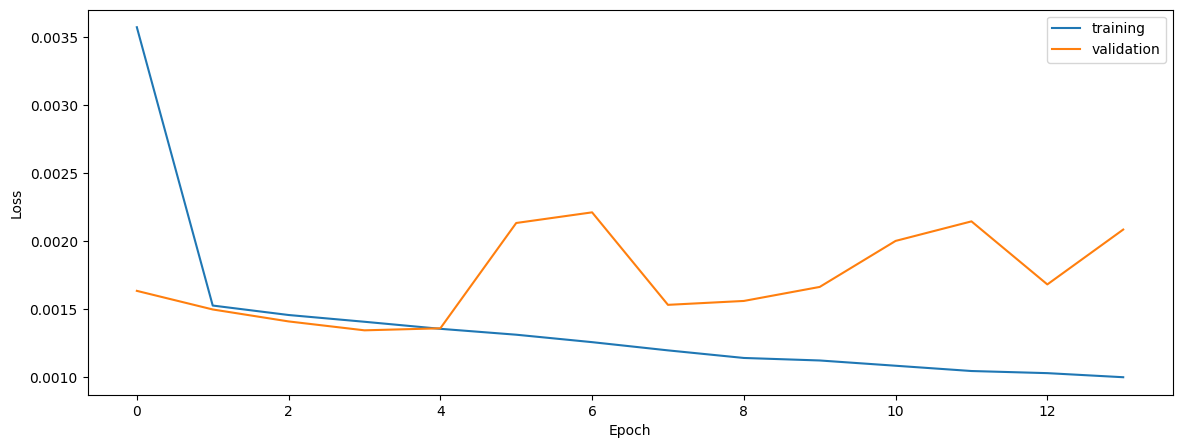

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.9460896064770423
0.9589330168972758
0.9485602773450319


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.9464229114030475
0.9550731191502334
0.9510780685263769


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.9528231283939732
0.9567599629752453
0.9624491260353768


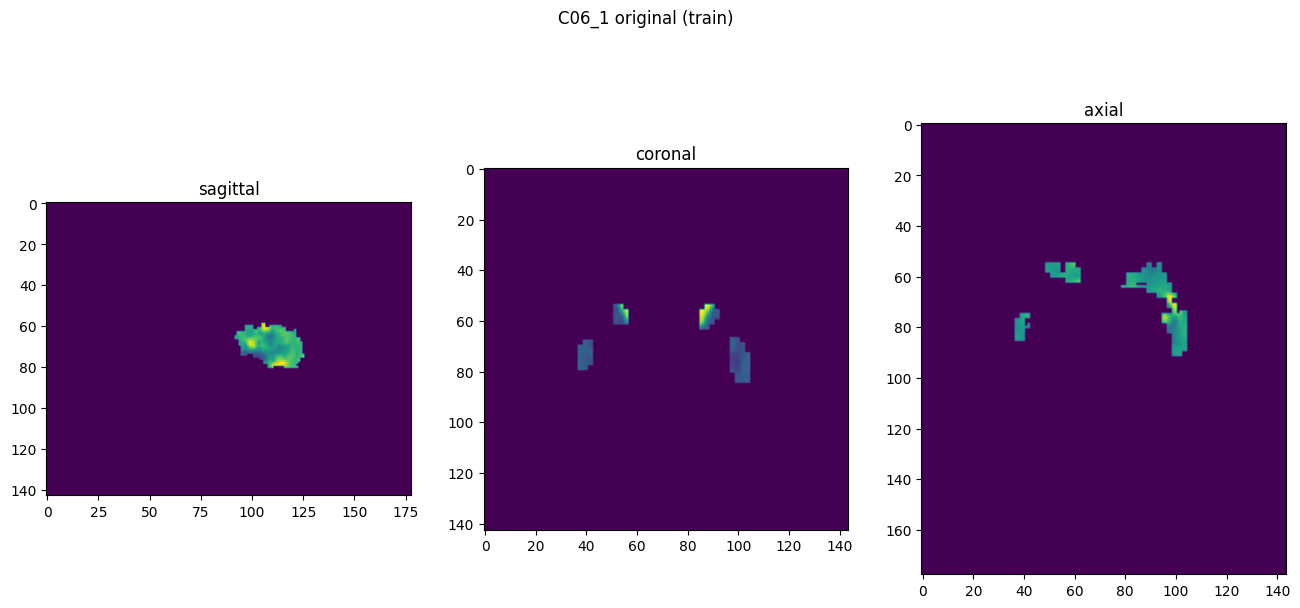

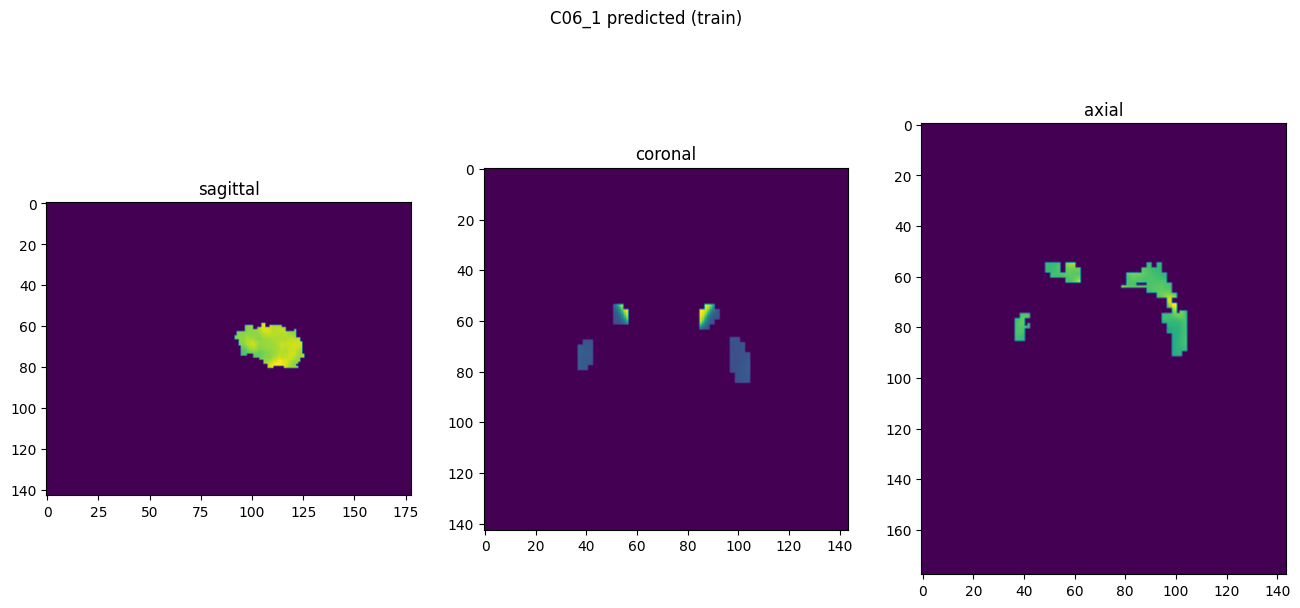

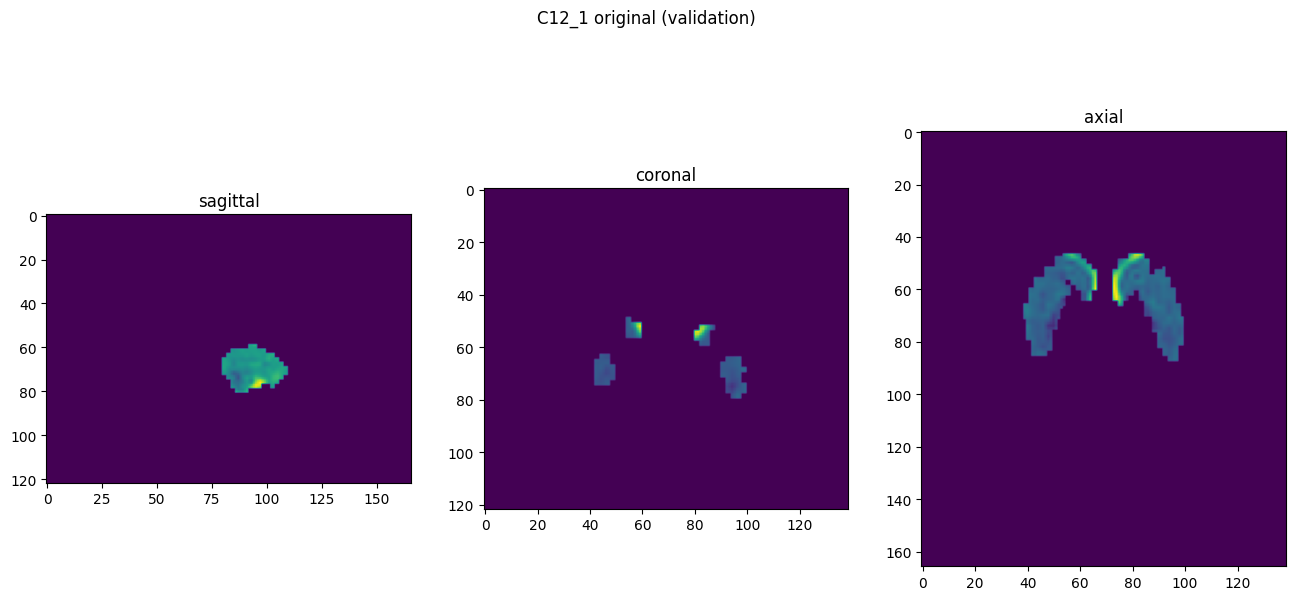

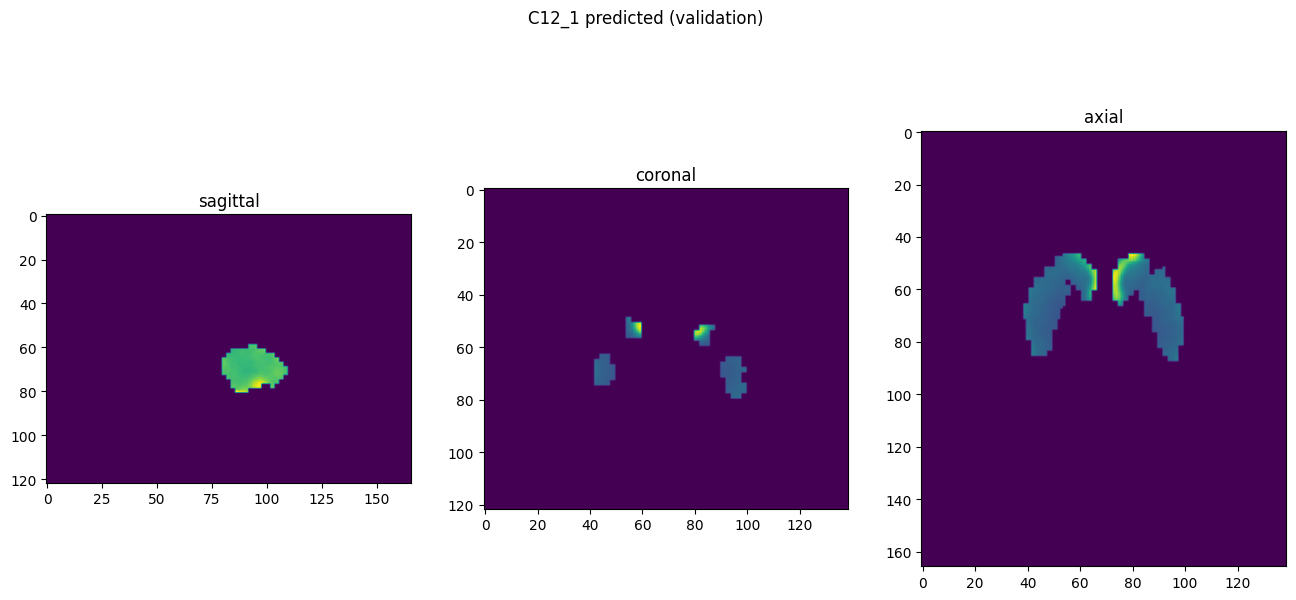

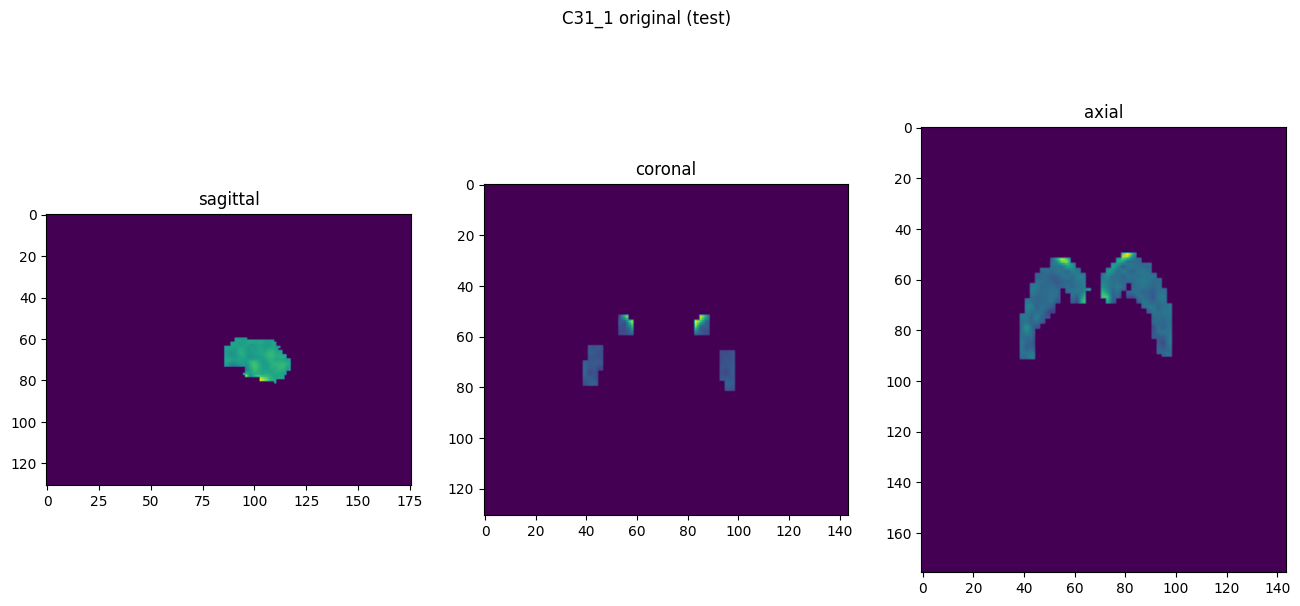

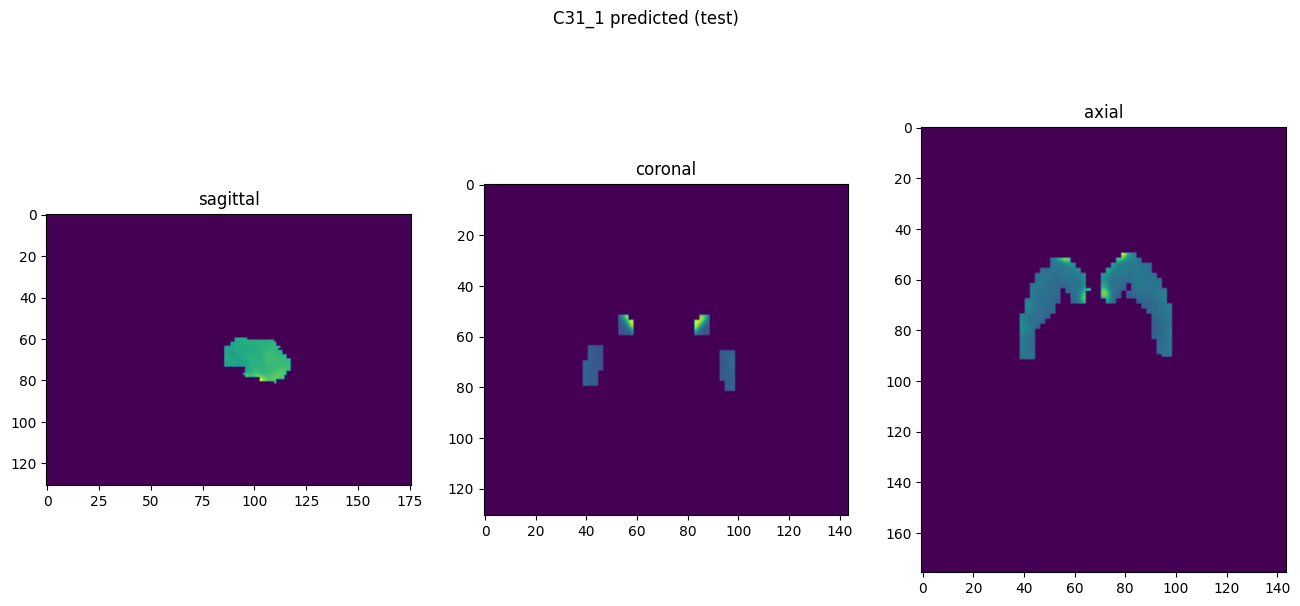

In [10]:
showResults(model, gen, threshold=None, background=False)